In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
                
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
                 
    return dot


In [213]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        
        out = Value(self.data * other.data, (self, other), '*')
    
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "can only handle int / float powers for now"
        
        out = Value(self.data ** other, (self,), '**')
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
            
        out._backward = _backward
        
        return out
    
    def exp(self):
        out = Value(math.exp(self.data), (self,), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
            
        out._backward = _backward
        
        return out
    
    def tanh(self):
        out = Value(math.tanh(self.data), (self,), 'tanh')
        
        def _backward():
            self.grad += (1 - out.data * out.data) * out.grad
            
        out._backward = _backward
        
        return out
    
    def zero_grad(self):
        self.grad = 0.0
        for child in self._prev:
            child.zero_grad()
    
    def backward(self):
        order = []
        visited = set()
        def build_topological_order(v):
            if v not in visited:
                visited.add(v)
                
                for child in v._prev:
                    build_topological_order(child)
                    
                order.append(v)
        
        build_topological_order(self)
        
        self.grad = 1.0
        for node in reversed(order):
            node._backward()
        
        

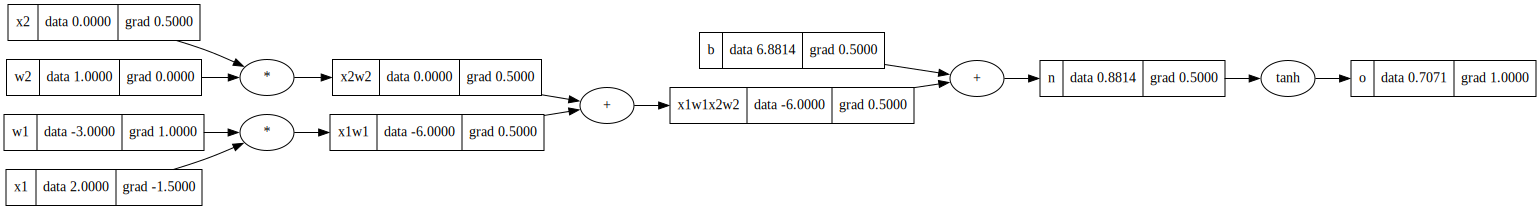

In [96]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

o.backward()
draw_dot(o)

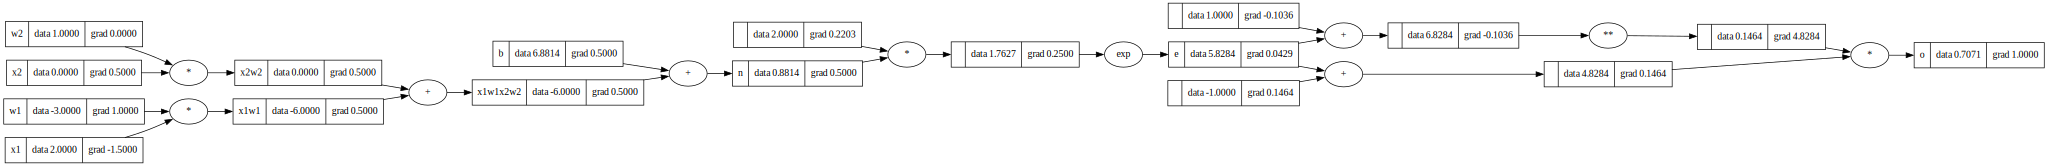

In [97]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp(); e.label = 'e'

o = (e - 1) / (e + 1); o.label = 'o'

o.zero_grad()
o.backward()
draw_dot(o)

In [34]:
import torch

x1 = torch.Tensor([2.0]).double()
x1.requires_grad = True

x2 = torch.Tensor([0.0]).double()
x2.requires_grad = True

w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True

w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]).double()
b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o)
print(o.data.item())
o.zero_grad()
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)
0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [31]:
torch.tensor([[1, 0, 0], [0, 1, 0], [0, 0, 1]]).double()

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], dtype=torch.float64)

In [106]:
import random

class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
        
    def __call__(self, x):
        act = sum((xi * wi for (xi, wi) in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs
    
    def parameters(self):
        return [param for neuron in self.neurons for param in neuron.parameters()]
    
class MLP:
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [param for layer in self.layers for param in layer.parameters()]

In [221]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])

In [222]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

In [230]:
learning_rate = 0.05

for k in range(20):
    ypred = [n(x)[0] for x in xs]
    loss = sum((yp - y) ** 2 for y, yp in zip(ys, ypred))

    loss.zero_grad()
    loss.backward()
    
    for p in n.parameters():
        p.data -= learning_rate * p.grad
        
    print(k, loss.data)

0 0.009167649083653358
1 0.00905555709556388
2 0.008946072555514413
3 0.008839107130167952
4 0.008734576388478313
5 0.00863239959017428
6 0.008532499487776542
7 0.008434802141152484
8 0.008339236743696445
9 0.008245735459297372
10 0.008154233269324357
11 0.00806466782892246
12 0.007976979331967013
13 0.007891110384076682
14 0.007807005883132212
15 0.007724612906790206
16 0.007643880606521191
17 0.007564760107736186
18 0.007487204415599625
19 0.007411168326155586


In [231]:
ypred

[Value(data=0.9558441873970885),
 Value(data=-0.9815622686213354),
 Value(data=-0.9450850599449636),
 Value(data=0.9541106552684382)]